In [19]:
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import tables
import os

from tierpsy_features.path import get_path_curvatures
from tierpsy.analysis.feat_init.smooth_skeletons_table import read_food_contour
from tierpsy_features.summary_stats import events_from_df

base_dir = '/Users/ajaver/OneDrive - Imperial College London/tierpsy_features/test_data/multiworm'

#skeletons_file = os.path.join(base_dir, 'N2_worms10_CSCD563206_10_Set9_Pos4_Ch6_25072017_214236_skeletons.hdf5')
skeletons_file = os.path.join(base_dir, 'MY16_worms5_food1-10_Set5_Pos4_Ch1_02062017_131004_skeletons.hdf5')
#skeletons_file = os.path.join(base_dir, 'MY23_worms5_food1-10_Set4_Pos5_Ch4_29062017_140148_skeletons.hdf5')
#skeletons_file = os.path.join(base_dir, '170817_matdeve_exp7co1_12_Set0_Pos0_Ch1_17082017_140001_skeletons.hdf5')

features_file = skeletons_file.replace('_skeletons.hdf5', '_featuresN.hdf5')

food_cnt = read_food_contour(skeletons_file)

with pd.HDFStore(features_file, 'r') as fid:
    blob_features = fid['/blob_features']
    trajectories_data = fid['/trajectories_data']
    timeseries_features = fid['/timeseries_features']
    
    fps = fid.get_node('/trajectories_data').attrs['fps']
    
good = trajectories_data['skeleton_id']>=0
trajectories_data = trajectories_data[good]
blob_features = blob_features[good]


event_df, event_durations = events_from_df(timeseries_features, fps)

In [20]:
trajectories_data_g = trajectories_data.groupby('worm_index_joined')
print(trajectories_data_g.groups.keys())
worm_index = 4#321#4#695

worm_data = trajectories_data_g.get_group(worm_index)
skel_id = worm_data['skeleton_id'].values 
with tables.File(features_file, 'r') as fid:
    skeletons = fid.get_node('/coordinates/skeletons')[skel_id, :, :]
    
worm_features = timeseries_features.loc[skel_id]
worm_events = event_df.loc[skel_id]



dict_keys([1, 2, 4, 5, 6, 8, 10, 11, 12, 13, 14, 19, 26, 27, 28, 29, 30, 42, 43, 44, 55, 56, 64, 66, 67, 68])


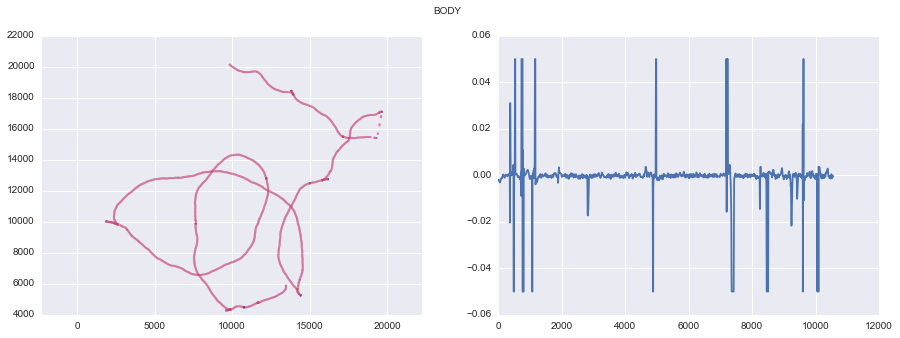

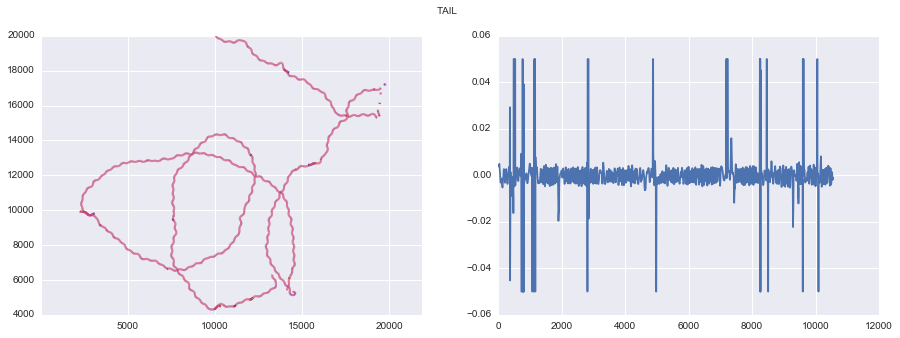

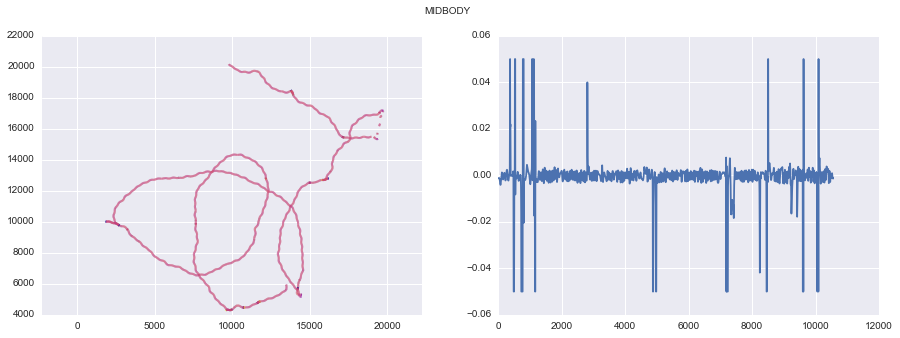

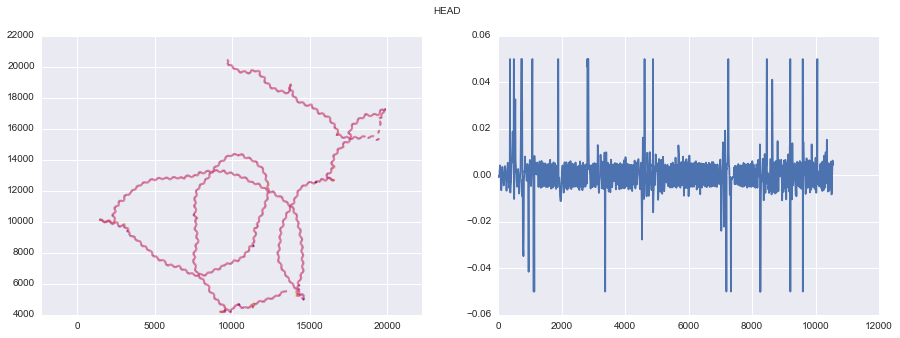

In [21]:
path_curvatures, path_coords = get_path_curvatures(skeletons)

r_clip = 0.05
for col in path_curvatures:
    path_curvature = path_curvatures[col].values
    
    dd = [col.replace('path_curvature', x) for x in ['coord_x', 'coord_y']]
    body_coords = path_coords[dd].values
    
    path_curvature = np.clip(path_curvature, -r_clip, r_clip)
    
    curv_range = (np.nanmin(path_curvature), np.nanmax(path_curvature))
    points = body_coords.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, 
                        cmap = plt.get_cmap('plasma'),
                        norm = plt.Normalize(*curv_range))
    lc.set_array(path_curvature)
    lc.set_linewidth(2)

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1,2,1)
    plt.gca().add_collection(lc)

    plt.xlim(3000, 11000)
    plt.ylim(3000, 11000)
    plt.axis('equal')
    
    plt.subplot(1,2,2)
    plt.plot(path_curvature)
    
    plt.suptitle(col.replace('path_curvature_', '').upper())


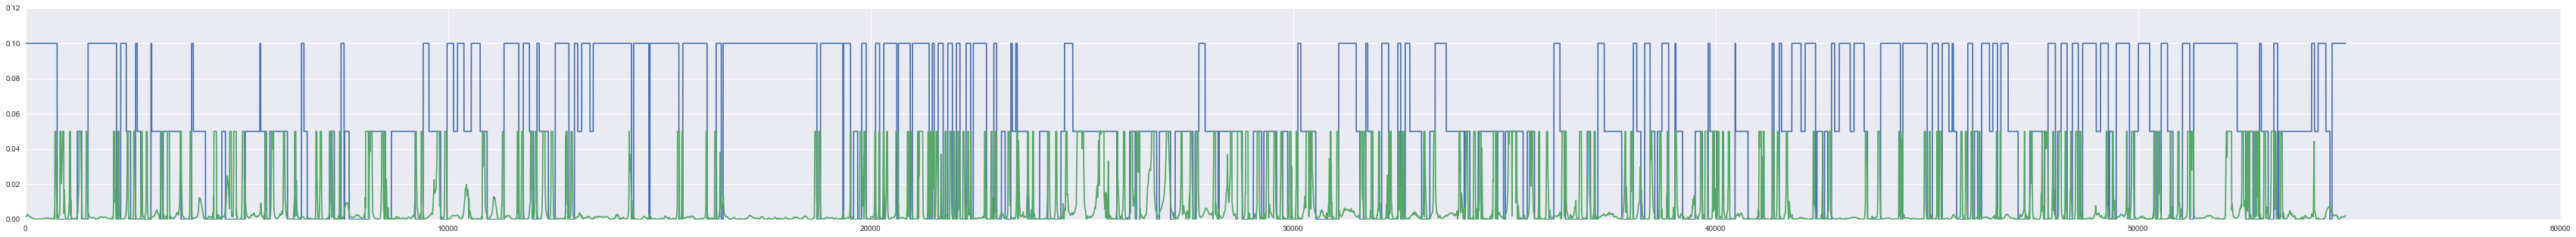

In [16]:
rr = 0.05


path_curvature = path_curvatures['path_curvature_body'].copy()
path_curvature = np.clip(path_curvature, -rr, rr)

motion_mode = worm_events['motion_mode'].values

plt.figure(figsize=(60, 5))

plt.plot((motion_mode+1)*rr)
plt.plot(np.abs(path_curvature))